# Защита персональных данных клиентов

Страховой компании «Хоть потоп» требуется защитить данные клиентов. Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. При этом качество моделей машинного обучения не должно ухудшаться. 

<font color='green'>Цель</font>

Разработать алгоритм защиты данных. 

<font color='green'>Задачи</font>

- исследовать данные;
- ответить на вопрос об изменении параметров линейной регрессии при умножении матрицы признаков на обратимую матрицу;
- разработать алгоритм защиты данных;
- проверить работу алгоритма;

<font color='green'>Файлы</font>

- `insurance.csv`

<font color='green'>Признаки</font>

-    Пол;
-    Возраст;
-    Зарплата;
-    Члены семьи.

<font color='green'>Целевой признак</font>

- `Страховые выплаты`.

<font color='green'>Содержание</font>

<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-признаков-на-обратимую-матрицу" data-toc-modified-id="Умножение-признаков-на-обратимую-матрицу-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение признаков на обратимую матрицу</a></span></li><li><span><a href="#Алгоритм-преобразования-данных." data-toc-modified-id="Алгоритм-преобразования-данных.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования данных.</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Стандартная-модель-c-модификацией-признаков" data-toc-modified-id="Стандартная-модель-c-модификацией-признаков-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Стандартная модель c модификацией признаков</a></span></li><li><span><a href="#Стандартная-модель-без-модификации-признаков" data-toc-modified-id="Стандартная-модель-без-модификации-признаков-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Стандартная модель без модификации признаков</a></span></li></ul></li></ul></div>

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_csv('/ML/datasets/insurance.csv')

In [3]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [6]:
data.duplicated().sum() 

153

В отсутствии уникального ID клиента, не будем считать найденные записи дубликатами.

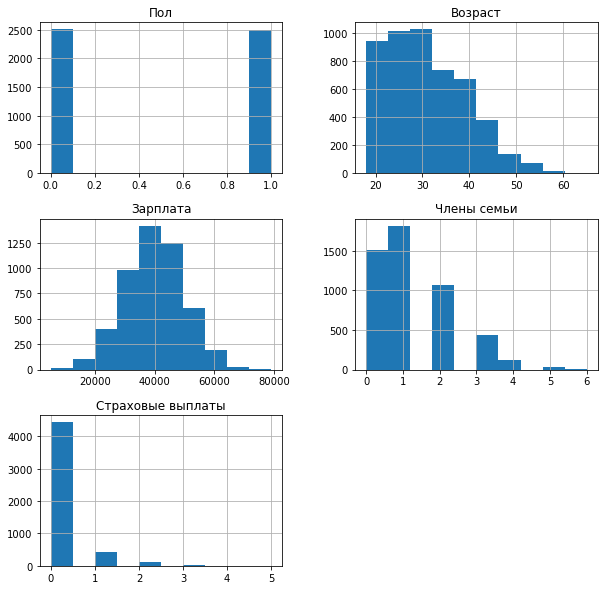

In [7]:
data.hist(figsize=(10, 10));

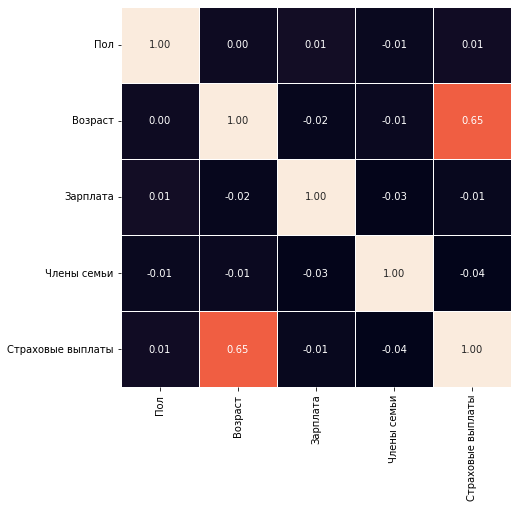

In [8]:
plt.figure(figsize=(7, 7))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

**Вывод**

Пропусков и дубликатов в данных не обнаружено. Наибольшая корреляция целевого признака наблюдается с параметром `'Возраст'`: 0,65. 

## Умножение признаков на обратимую матрицу

Проверим как изменяются параметры линейной регрессии при умножении признаков на обратимую матрицу.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)
- $y$ — вектор целевого признака
- $P$ — матрица, на которую умножаются признаки
- $P^{-1}$ — матрица, обратная к $P$
- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)
- $E$ — единичная матрица

$$
w_1 = (X^T X)^{-1} X^T y
$$

$$
w_2 = ((XP)^T XP)^{-1} (XP)^T y
$$

Приравняем $w_1$ к $w_2$ и раскроем скобки, воспользовавшись следующими свойствами: 

$(AB)^{T} = B^{T}A^{T}$

$(AB)^{-1} = B^{-1}A^{-1}$

$AA^{-1} = A^{-1}A =  E$

$$(X^T X)^{-1} X^T y \stackrel{?}{=} ((XP)^T XP)^{-1} (XP)^T y
$$

$$(X^T X)^{-1} X^T y\stackrel{?}{=}(P^T (X^T X) P)^{-1} P^T X^T y 
$$

$$(X^T X)^{-1} X^T y\stackrel{?}{=}P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y 
$$

$$(X^T X)^{-1} X^T y\stackrel{?}{=}P^{-1} (X^T X)^{-1} E X^T y 
$$

$$w_2=P^{-1}w_1
$$

Предсказания:

$$a_1 = Xw_1
$$

$$a_2 = XPw_2 = XPP^{-1}w_1 = Xw_1
$$

$$a_1 = a_2
$$

Предсказания модели не изменились.

**Вывод**

При умножении признаков на обратимую матрицу $P$ параметры линейной регресии не изменяются.

## Алгоритм преобразования данных.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)
- $y$ — вектор целевого признака
- $P$ — матрица, на которую умножаются признаки
- $P^{-1}$ — матрица, обратная к $P$
- $data$ - данные
- $E$ - единичная матрица

В качестве алгоритма защиты данных предлагается следующая последовательность шагов:

1) Создать рандомную матрицу $P$ размера n*n, где n - кол-во признаков.

2) Проверить обратимость матрицы $P$. В случае возникновения ошибки вернуться к пункту 1).

3) Умножить матрицу признаков на матрицу $P$.

C этого этапа данные о клиентах хрянятся в зашифрованном виде. Ключ - матрица $P$.

4) Далее работа ведется по стандартному алгоритму ML. 

**Обоснование**
Т.к. создаваемая нами для шифрования матрица является обратимой, то она имеет обратную матрицу. Исходя из свойств обратной и единичной матриц имеем:

$$
XP^{-1}P = XE= X
$$

В любой момент, при необходимости, мы имеем возможность восстановить исходные данные. При этом, согласно ранее сделанным выводам, для обучения алгоритма ML этого не требуется.


**Вывод**

В качестве алгоритма защиты данных предложено шифрование методом умножения матриц. 

## Проверка алгоритма

### Подготовка данных

Создание обратной матрицы:

In [9]:
def rnd_matrix(n):
    random_matrix = np.random.normal(size=(n, n))
    try:
        np.linalg.inv(random_matrix) 
    except LinAlgError:
        rnd_matrix(n)
    return random_matrix

In [10]:

target = data['Страховые выплаты']
features = data.drop(['Страховые выплаты'] , axis=1)
features_modify = np.dot(features, rnd_matrix(len(features.columns)))

result = pd.DataFrame(index=['R2']) #датафрейм для хранения результатов работы моделей

### Стандартная модель c модификацией признаков

In [11]:
features_train_modify, features_test_modify, target_train, target_test = train_test_split(
    features_modify, target, test_size=0.20, random_state=12345)
print(features_train_modify.shape, target_train.shape, features_test_modify.shape, target_test.shape)

(4000, 4) (4000,) (1000, 4) (1000,)


In [12]:
param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
}

model = LinearRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, refit='r2_score')
grid_search.fit(features_train_modify, target_train)
predicted_test = grid_search.best_estimator_.predict(features_test_modify)

print('R2:{:.3f}'.format(r2_score(target_test, predicted_test)))
print("Slopes:", grid_search.best_estimator_.coef_)
print("Intercept:", grid_search.best_estimator_.intercept_)

result['Стандартная модель c модификацией признаков'] = [r2_score(target_test, predicted_test)] # сохранение результата

R2:0.412
Slopes: [ 0.04254897 -0.05418629  0.04957844 -0.01084399]
Intercept: -0.949050223637787


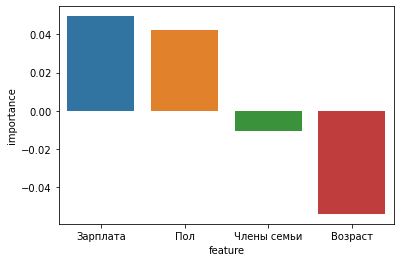

In [13]:
featureImportance = pd.DataFrame({"feature": data.drop(['Страховые выплаты'] , axis=1).columns, 
                                  "importance": grid_search.best_estimator_.coef_})

featureImportance.set_index("feature", inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
sns.barplot(x=featureImportance.index, y='importance', data=featureImportance);

### Стандартная модель без модификации признаков

In [14]:
features_train, features_test = train_test_split(features, test_size=0.20, random_state=12345)
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(4000, 4) (4000,) (1000, 4) (1000,)


In [15]:
param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
}

model = LinearRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, refit='r2_score')
grid_search.fit(features_train, target_train)
predicted_test = grid_search.best_estimator_.predict(features_test)

print('R2:{:.3f}'.format(r2_score(target_test, predicted_test)))
print("Slopes:", grid_search.best_estimator_.coef_)
print("Intercept:", grid_search.best_estimator_.intercept_)

result['Стандартная модель без модификации признаков'] = [r2_score(target_test, predicted_test)] # сохранение результата

R2:0.412
Slopes: [ 1.03381395e-02  3.61850636e-02 -3.43919648e-07 -1.25501642e-02]
Intercept: -0.9490502236348631


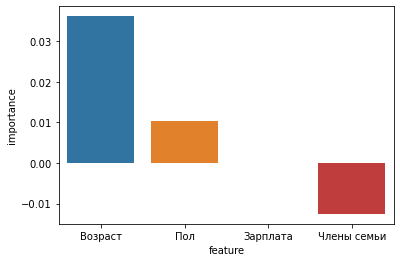

In [16]:
featureImportance = pd.DataFrame({"feature": data.drop(['Страховые выплаты'] , axis=1).columns, 
                                  "importance": grid_search.best_estimator_.coef_})

featureImportance.set_index("feature", inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
sns.barplot(x=featureImportance.index, y='importance', data=featureImportance);

**Вывод**

In [17]:
result = result.T
result

,R2
Стандартная модель c модификацией признаков,0.411768
Стандартная модель без модификации признаков,0.411768


Для защиты данных пользователей в работе предложено шифрование методом умножения матриц. В качестве ключа, при необходимости получения первоначальной информации, используется  обратимая матрица $P$. Применение алгоритма к данным не влияет на предсказания линейной регрессии, при этом стоит отметить изменение коэффициентов самой модели.